In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
from typing import List


In [34]:
def get_bert_embeddings(sentences: List[str], model_name: str = "batterydata/batterybert-cased-abstract") -> np.ndarray:
    """
    Generate embeddings for a list of texts using BatteryBERT model.
    
    Args:
        sentences: List of strings to embed
        model_name: HuggingFace model name
        
    Returns:
        numpy array of embeddings
    """
    # Set device to CUDA if available, otherwise CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    
    # Move model to appropriate device
    model = model.to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Initialize empty array for embeddings
    embeddings = []
    
    # Process in batches to prevent memory issues
    batch_size = 8
    
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i + batch_size]
        
        # Tokenize inputs
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=512)
        
        # Move inputs to device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Get model output
        with torch.no_grad():
            outputs = model(**inputs)
            
        # Use the [CLS] token embeddings as the sentence representation
        # Move tensor to CPU before converting to numpy
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.extend(batch_embeddings)
    
    return np.array(embeddings)

def visualize_embeddings(embeddings: np.ndarray, method: str = "tsne"):
    """
    Visualize embeddings using dimensionality reduction without labels.
    
    Args:
        embeddings: Numpy array of embeddings
        method: Dimensionality reduction method ('tsne' or 'pca')
    """
    # Create a DataFrame for easier plotting
    if method.lower() == "tsne":
        # Use t-SNE for dimensionality reduction
        tsne = TSNE(n_components=2, perplexity=min(30, len(embeddings)-1), 
                    random_state=42, n_iter=1000)
        reduced_embeddings = tsne.fit_transform(embeddings)
        title = "t-SNE Visualization of BatteryBERT Embeddings"
    else:
        # Use PCA for dimensionality reduction
        pca = PCA(n_components=2)
        reduced_embeddings = pca.fit_transform(embeddings)
        explained_var = pca.explained_variance_ratio_
        title = f"PCA Visualization of BatteryBERT Embeddings\nExplained variance: {explained_var[0]:.2f}, {explained_var[1]:.2f}"
    
    # Create DataFrame for plotting
    df = pd.DataFrame({
        'x': reduced_embeddings[:, 0],
        'y': reduced_embeddings[:, 1]
    })
    
    # Plot the reduced embeddings without labels
    plt.figure(figsize=(12, 8))
    plt.scatter(df['x'], df['y'], s=100, alpha=0.8, c='steelblue')
    plt.title(title, fontsize=16)
    plt.xlabel("Dimension 1", fontsize=12)
    plt.ylabel("Dimension 2", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Add correlation heatmap for the original embeddings
    plt.figure(figsize=(10, 8))
    correlation = np.corrcoef(embeddings)
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    sns.heatmap(correlation, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, 
                square=True, linewidths=.5, cbar_kws={"shrink": .8})
    plt.title("Correlation Heatmap of Embedding Dimensions", fontsize=16)
    plt.tight_layout()
    plt.show()

def analyze_clusters(embeddings: np.ndarray, texts: List[str], n_clusters: int = 3):
    """
    Perform clustering analysis on embeddings.
    
    Args:
        embeddings: Numpy array of embeddings
        texts: List of original texts
        n_clusters: Number of clusters to form
    """
    from sklearn.cluster import KMeans
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings)
    
    # Create a DataFrame with texts and their clusters
    cluster_df = pd.DataFrame({
        'text': texts,
        'cluster': clusters
    })
    
    # Display cluster information
    print("\nClustering Results:")
    for cluster_id in range(n_clusters):
        print(f"\nCluster {cluster_id}:")
        cluster_texts = cluster_df[cluster_df['cluster'] == cluster_id]['text'].values
        for i, text in enumerate(cluster_texts[:5]):  # Show first 5 texts in each cluster
            print(f"  {i+1}. {text[:100]}{'...' if len(text) > 100 else ''}")
        if len(cluster_texts) > 5:
            print(f"  ... and {len(cluster_texts)-5} more texts")
    
    # Visualize clusters
    # Use t-SNE to reduce dimensionality
    tsne = TSNE(n_components=2, perplexity=min(30, len(embeddings)-1), 
                random_state=42, n_iter=1000)
    reduced_embeddings = tsne.fit_transform(embeddings)
    
    # Create a DataFrame for plotting with cluster information
    df = pd.DataFrame({
        'x': reduced_embeddings[:, 0],
        'y': reduced_embeddings[:, 1],
        'cluster': clusters
    })
    
    # Plot clusters
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(df['x'], df['y'], c=df['cluster'], cmap='viridis', 
                         s=100, alpha=0.8)
    plt.colorbar(scatter, label='Cluster')
    plt.title("Clusters Visualization (t-SNE)", fontsize=16)
    plt.xlabel("Dimension 1", fontsize=12)
    plt.ylabel("Dimension 2", fontsize=12)
    plt.tight_layout()
    plt.show()

In [ ]:
from sib.literature.lit_processing import read_json
import os

Generating BatteryBERT embeddings...
Using device: cuda
Generated embeddings with shape: (5074, 768)

Visualizing embeddings with t-SNE...


C:\Users\Subways-Sun\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


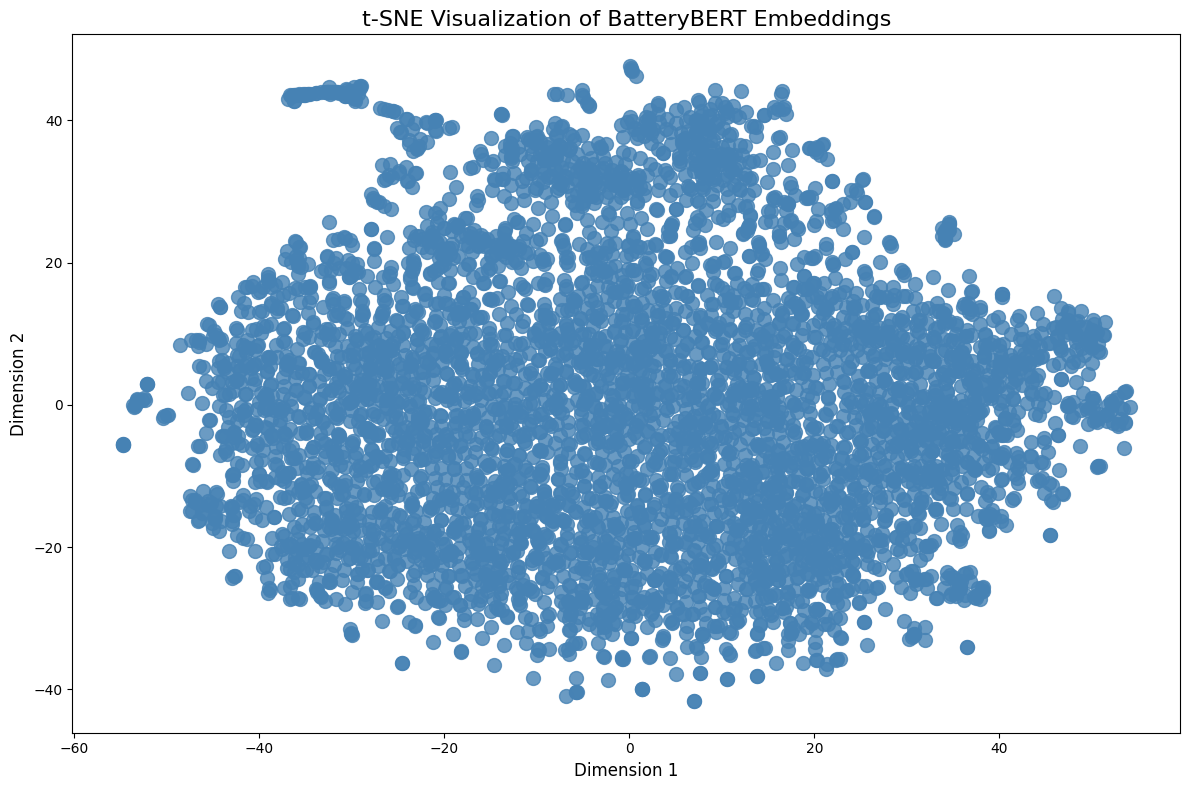

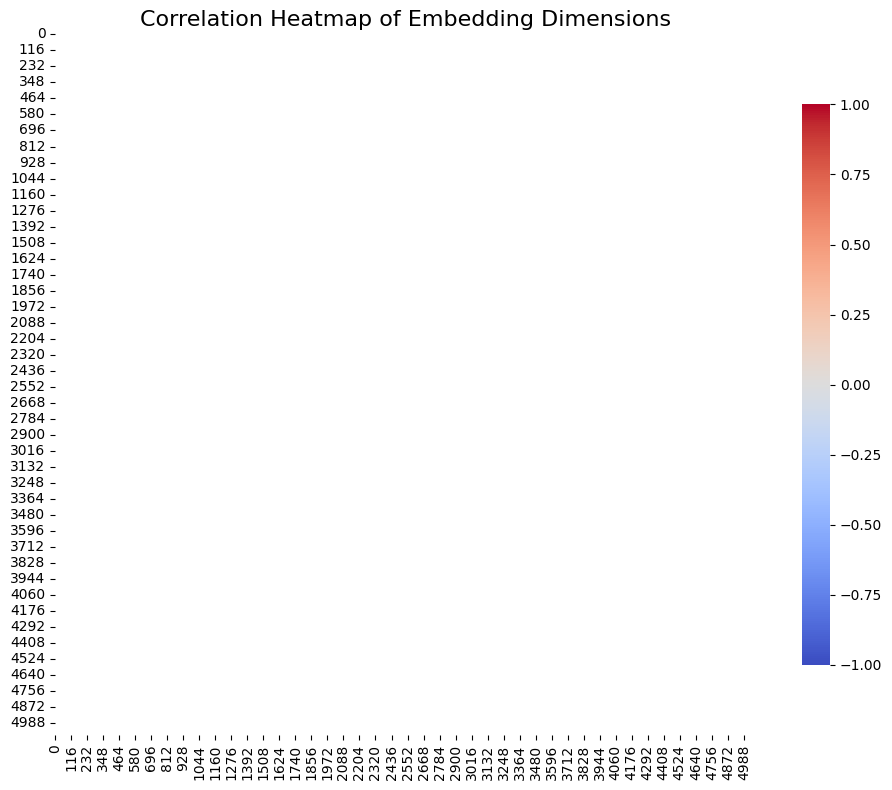


Visualizing embeddings with PCA...


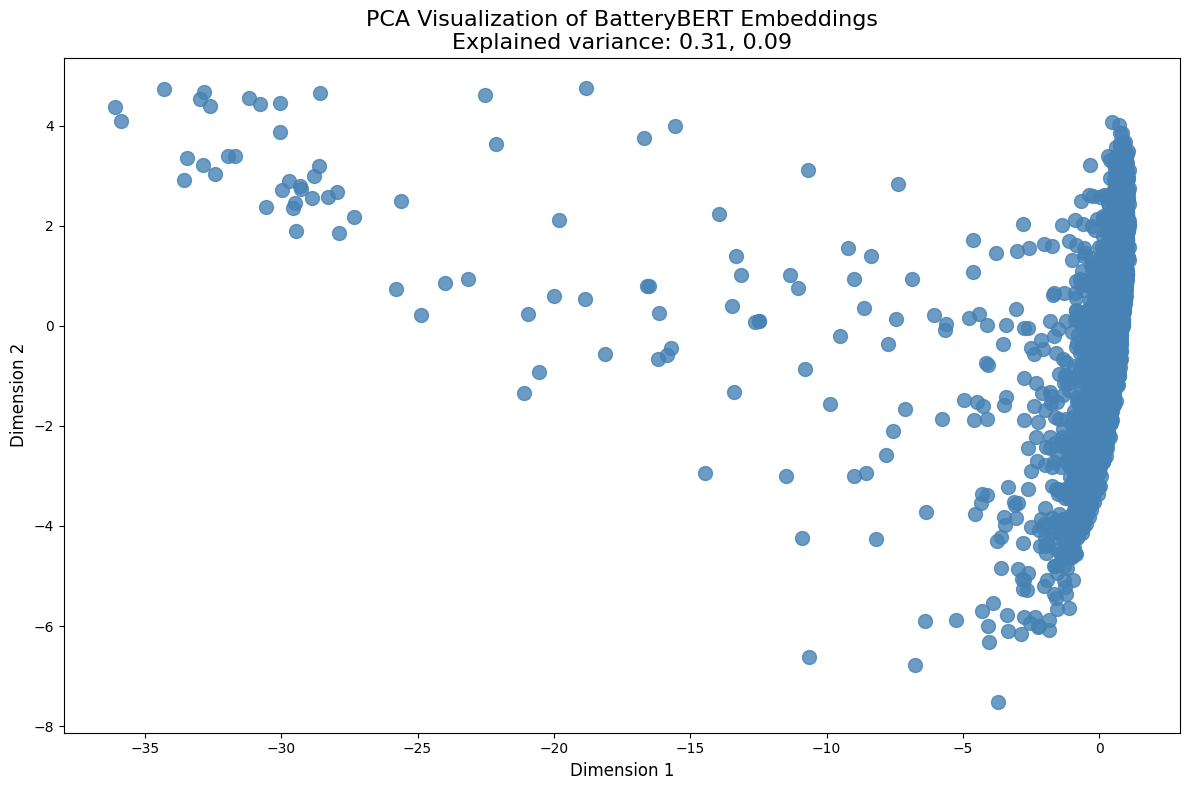

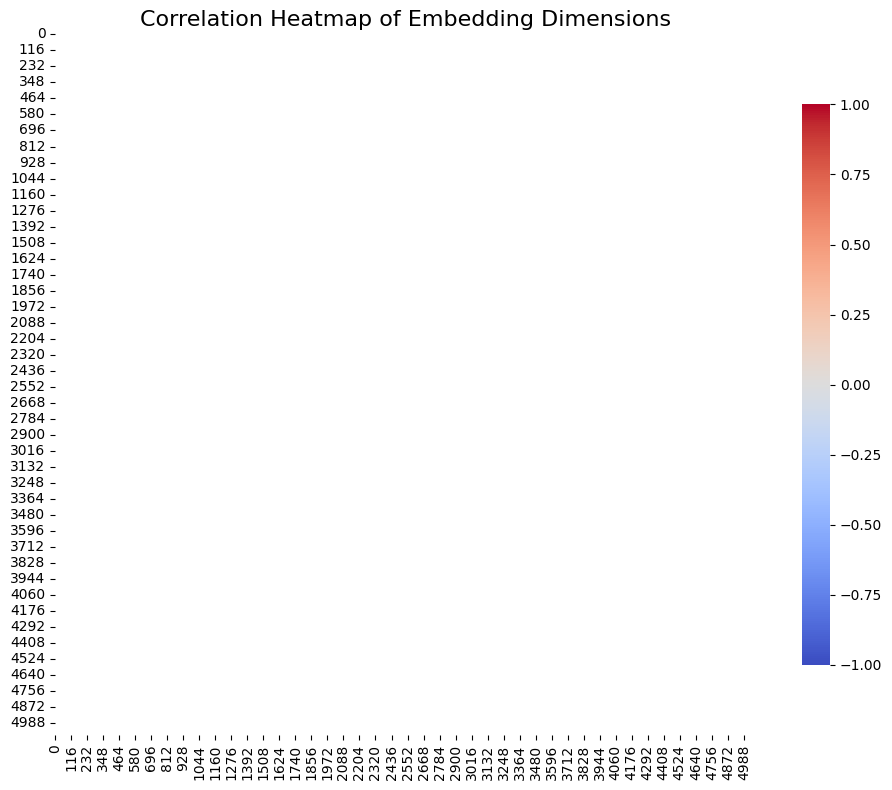


Performing clustering analysis...

Clustering Results:

Cluster 0:
  1. As an emerging class of layered transition metal carbides/nitrides/carbon-nitrides, MXenes have been...
  2. Hard carbon (HC), a commercially available anode for sodium-ion batteries(SIBs), suffers from the un...
  3. Abstract Hybrid ion capacitors (HICs) have aroused extreme interest due to their combined characteri...
  4. Abstract Practical aqueous zinc‐ion batteries require low‐cost thin zinc anodes with long‐term rever...
  5. Abstract Covalent triazine frameworks (CTFs) are normally synthesized by ionothermal methods. The ha...
  ... and 48 more texts

Cluster 1:
  1. Rational construction of nanosized anode nanomaterials is crucial to enhance the electrochemical per...
  2. Development of the next-generation, high-energy-density, low-cost batteries will likely be fueled by...
  3. Sluggish reaction kinetics induced by the inferior solid-state ion diffusion and poor conductivity o...
  4. Huge volume changes

C:\Users\Subways-Sun\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


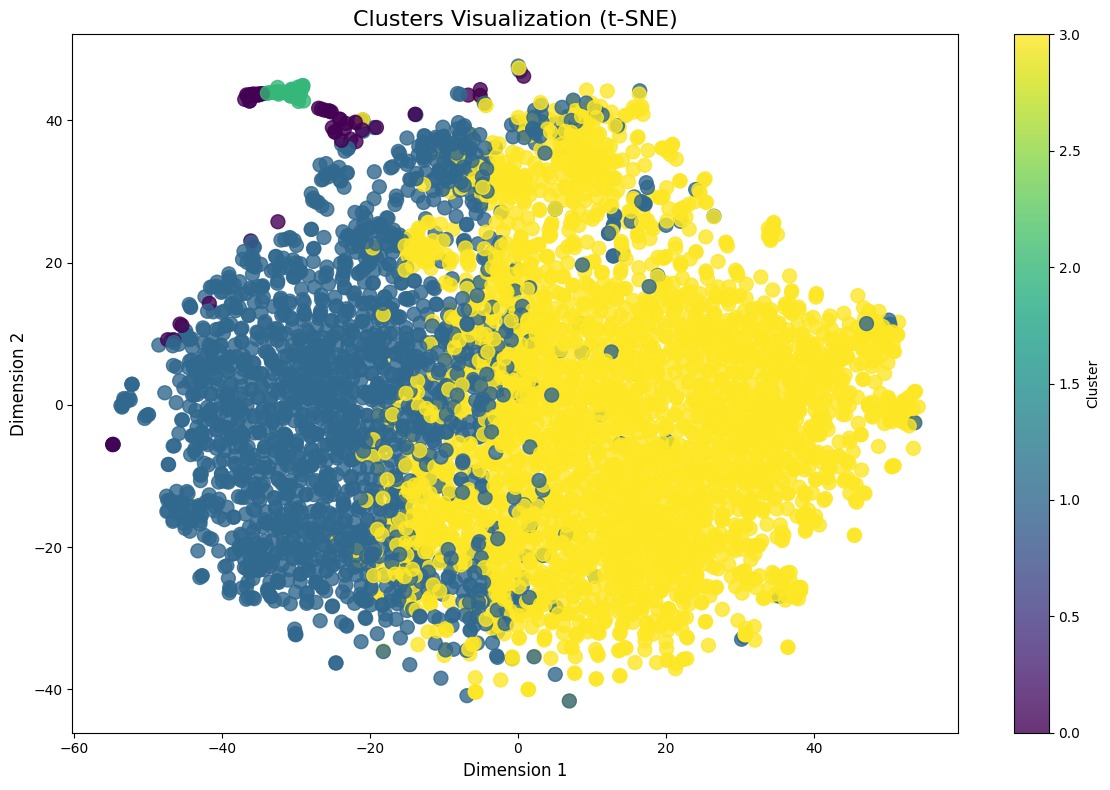

In [35]:
pre_classification = read_json(r"C:\Users\Subways-Sun\OneDrive\Documents\GitHub\sodium-ion-batteries\data\search_20250313-003348.json")
classified = read_json(r"C:\Users\Subways-Sun\OneDrive\Documents\GitHub\sodium-ion-batteries\data_annotated\search_20250313-003348_openai_relevant.json")

pre_classification_texts = [item['abstract'] for item in pre_classification]
classified_texts = [item['abstract'] for item in classified]

texts = pre_classification_texts

print("Generating BatteryBERT embeddings...")
embeddings = get_bert_embeddings(texts)
print(f"Generated embeddings with shape: {embeddings.shape}")

# Visualize using t-SNE (without labels)
print("\nVisualizing embeddings with t-SNE...")
visualize_embeddings(embeddings, method="tsne")

# Visualize using PCA (without labels)
print("\nVisualizing embeddings with PCA...")
visualize_embeddings(embeddings, method="pca")

# Perform clustering analysis
print("\nPerforming clustering analysis...")
analyze_clusters(embeddings, texts, n_clusters=4)

Generating BatteryBERT embeddings...
Using device: cuda
Generated embeddings with shape: (3828, 768)

Visualizing embeddings with t-SNE...


C:\Users\Subways-Sun\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


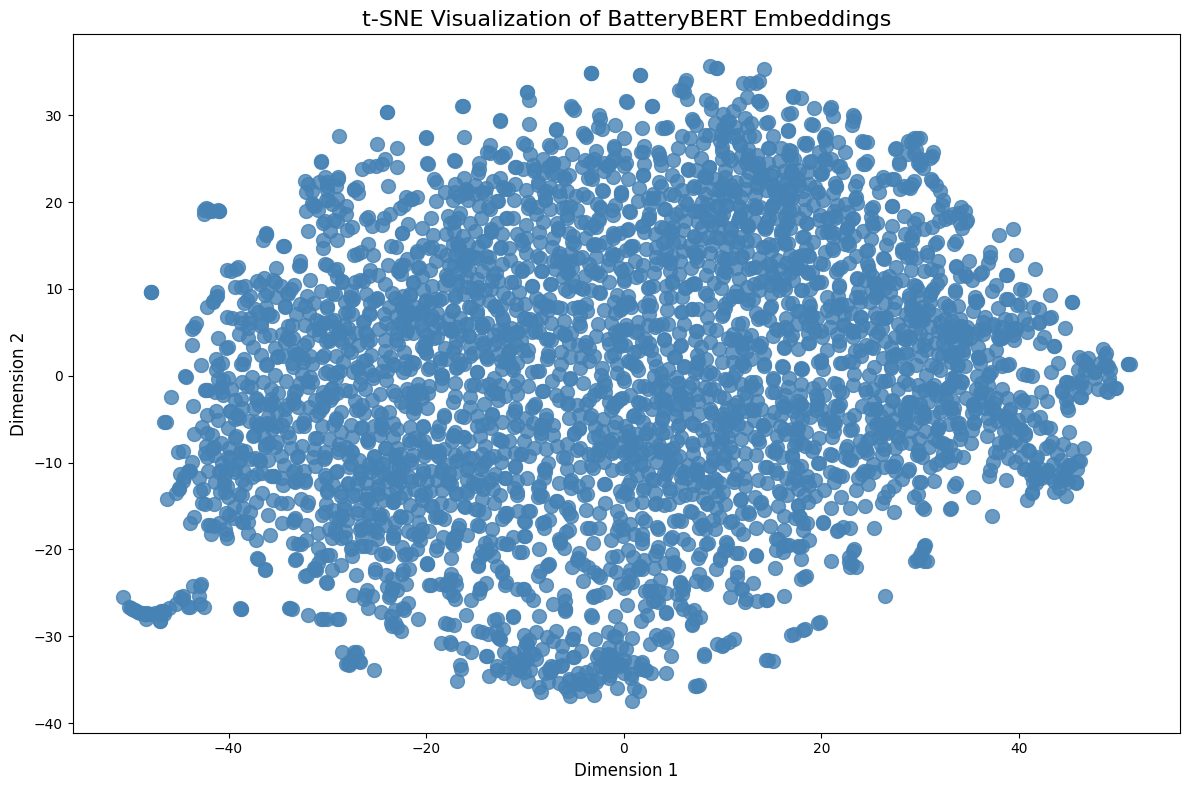

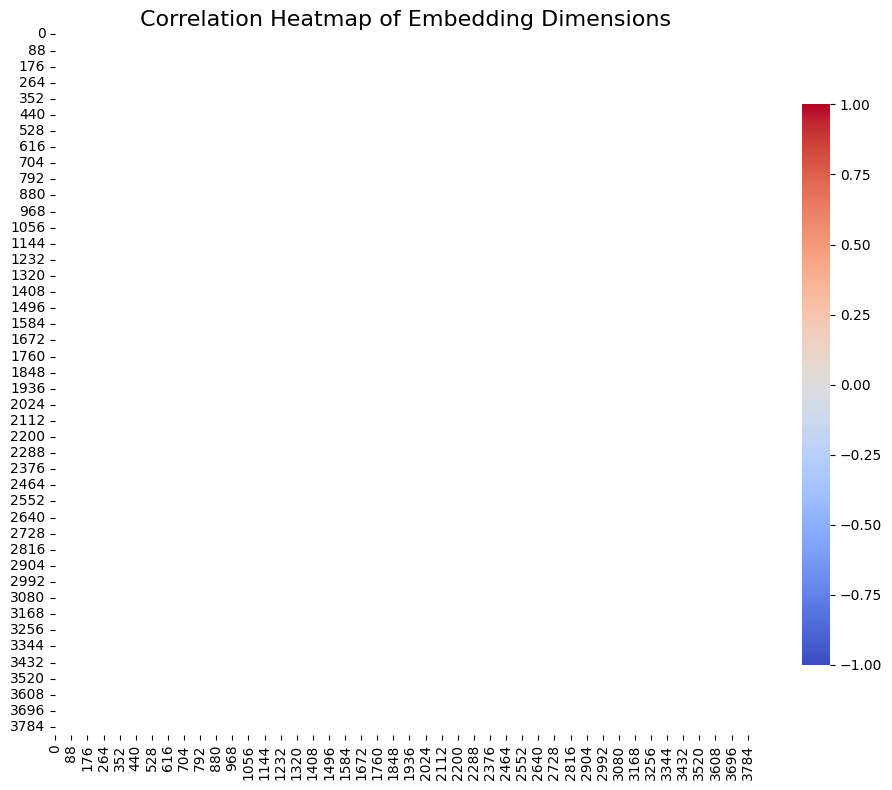


Visualizing embeddings with PCA...


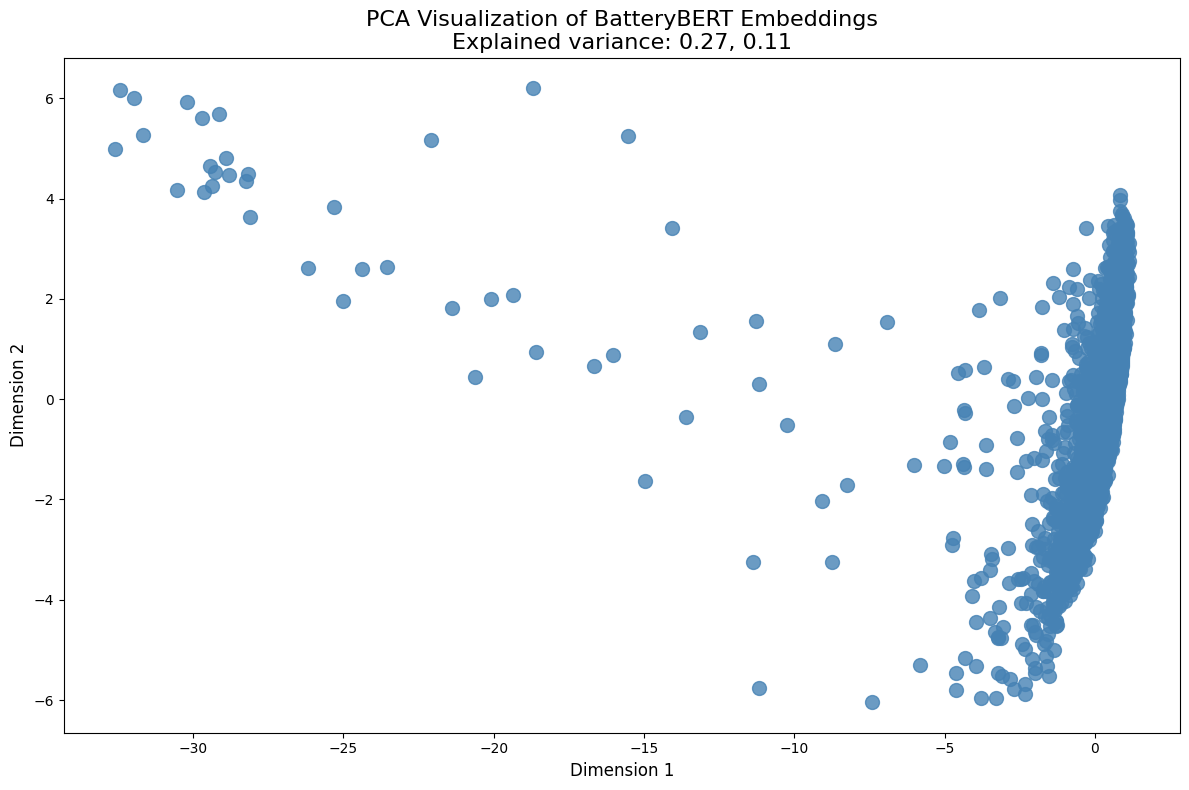

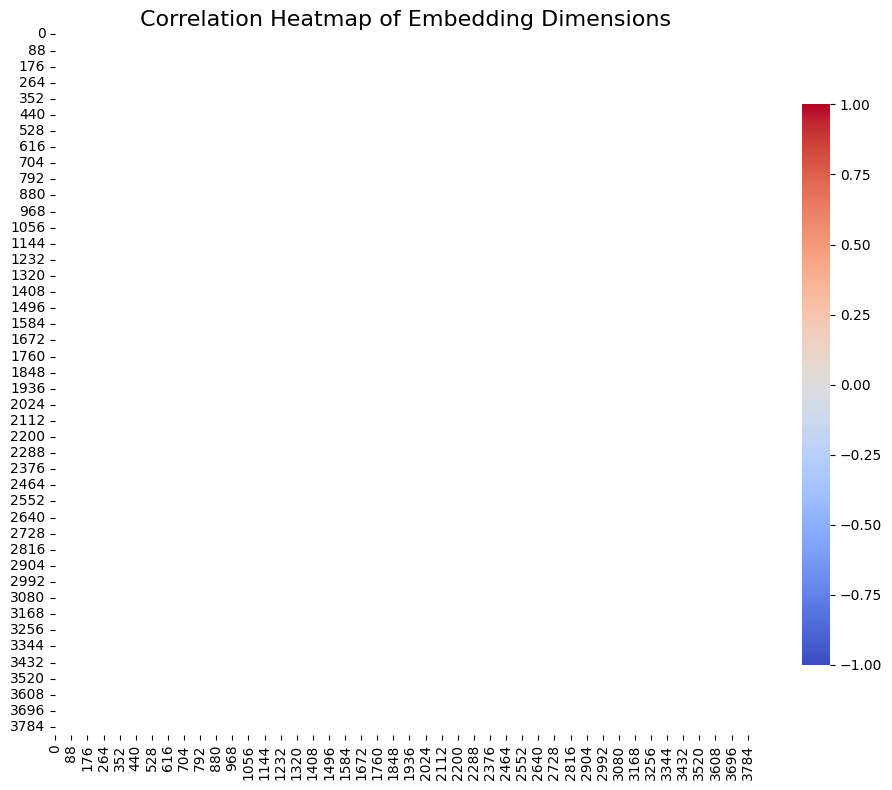


Performing clustering analysis...

Clustering Results:

Cluster 0:
  1. Rational construction of nanosized anode nanomaterials is crucial to enhance the electrochemical per...
  2. Huge volume changes of bismuth (Bi) anode leading to rapid capacity hindered its practical applicati...
  3. Hard carbons (HCs), while a leading candidate for sodium-ion battery (SIB) anode materials, face cha...
  4. Peapod-like carbon-encapsulated cobalt chalcogenide nanowires are designed and synthesized by a faci...
  5. The significance of exploring optimal electrode materials cannot be overstated, particularly in miti...
  ... and 449 more texts

Cluster 1:
  1. Metallic selenides have been widely investigated as promising electrode materials for metal-ion batt...
  2. Cellulose, as it has high content and low cost along with the absence of heteroatoms, can well balan...
  3. Aqueous sodium-ion batteries (SIBs) are gradually being recognized as viable solutions for large-sca...
  4. Hard Carbon (HC) h

C:\Users\Subways-Sun\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


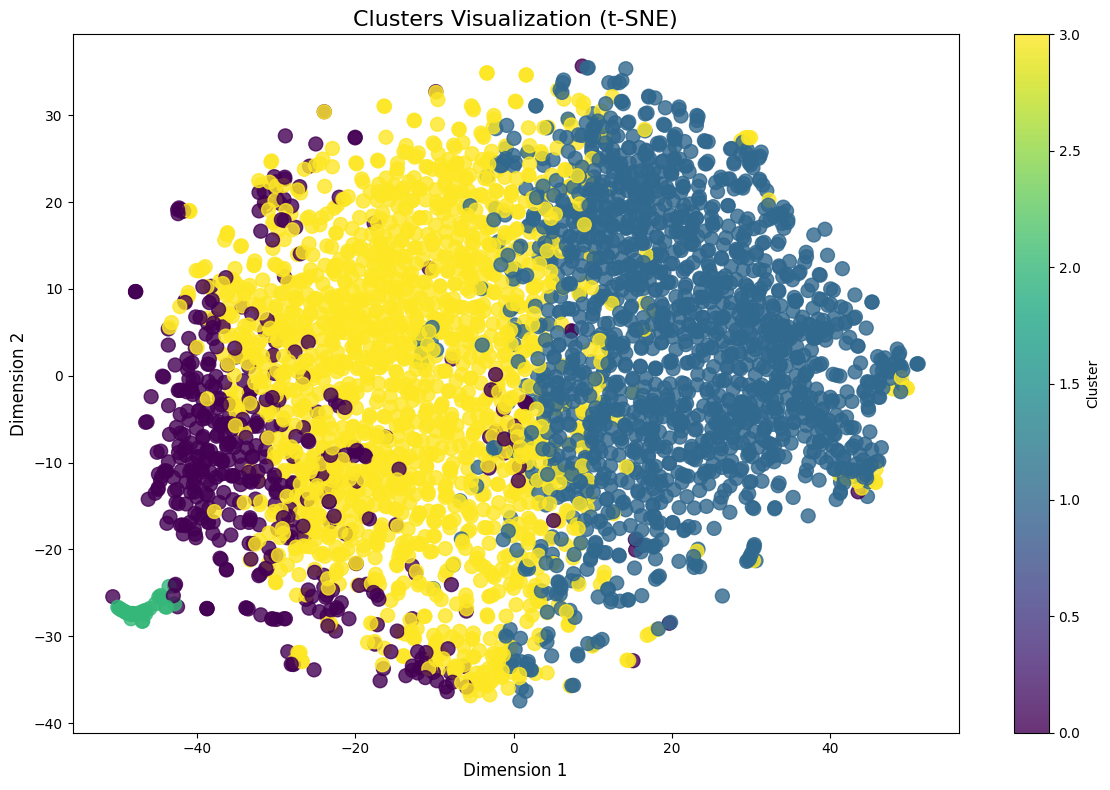

In [36]:
pre_classification = read_json(r"C:\Users\Subways-Sun\OneDrive\Documents\GitHub\sodium-ion-batteries\data\search_20250313-003348.json")
classified = read_json(r"C:\Users\Subways-Sun\OneDrive\Documents\GitHub\sodium-ion-batteries\data_annotated\search_20250313-003348_openai_relevant.json")

pre_classification_texts = [item['abstract'] for item in pre_classification]
classified_texts = [item['abstract'] for item in classified]

texts = classified_texts

print("Generating BatteryBERT embeddings...")
embeddings = get_bert_embeddings(texts)
print(f"Generated embeddings with shape: {embeddings.shape}")

# Visualize using t-SNE (without labels)
print("\nVisualizing embeddings with t-SNE...")
visualize_embeddings(embeddings, method="tsne")

# Visualize using PCA (without labels)
print("\nVisualizing embeddings with PCA...")
visualize_embeddings(embeddings, method="pca")

# Perform clustering analysis
print("\nPerforming clustering analysis...")
analyze_clusters(embeddings, texts, n_clusters=4)